In [251]:
import csv
import os

import numpy as np
import pandas as pd
#from owid_downloader import GenerateTrainingData
#from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from stan_sirvc_layer import run_layer, get_features
import matplotlib.dates as mdates

In [252]:
#GenerateTrainingData().download_jhu_data('2020-08-01', '2020-12-01')
start_date = '2021-01-01'
end_date = '2021-05-31'

In [253]:
# data processing
raw_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases_smoothed", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date)
raw_data = raw_data.loc[mask]

countries = []
loc_list = list(raw_data['location'].unique())
# only include countries that have more than 1000 total cases on start date and at least 1 death
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_cases"].values[0] > 1000 and \
        raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded; these are problematic locations (non-countries) that need to be removed
countries.remove("European Union")
countries.remove("Europe")
countries.remove("Africa")
countries.remove("Asia")
countries.remove("North America")
countries.remove("Oceania")
countries.remove("South America")
countries.remove("World")
countries.remove("Tajikistan")
continents = ["Europe", "Africa", "Asia", "North America", "South America", "Oceania"]
world = ["World"]

country_mask = raw_data['location'].isin(countries)
continent_mask = raw_data['location'].isin(continents)
world_mask = raw_data['location'].isin(world)

country_raw_data = raw_data.loc[country_mask]
continent_raw_data = raw_data.loc[continent_mask]
world_raw_data = raw_data.loc[world_mask]

print(len(country_raw_data['location'].unique()))   # 163
print(len(continent_raw_data['location'].unique())) # 6
print(len(world_raw_data['location'].unique()))     # 1

163
6
1


In [254]:
# regular continents
continent_to_country = {'Europe':[], 'Asia':[], 'Africa':[], 'North America':[], 'South America':[], 'Oceania':[]}
match_countries = True # mix up country to continent matching for experiment

if match_countries == True:
    continent_reader = csv.reader(open('Countries-Continents.csv', 'r'))
    for row in continent_reader:
        if row[1] in countries:
            continent_to_country[row[0]].append(row[1])
    countries_in_dict = []
    for k,v in continent_to_country.items():
        print(f"{k}: {len(v)} countries")

# randomly sample continents
else:
    import random
    random.shuffle(countries)
    for i,continent in enumerate(continents):
        continent_to_country[continent] = countries[i*27:i*27+27]
        if i == 5:
            continent_to_country[continent].append(countries[-1])

print(continent_to_country)

Europe: 47 countries
Asia: 37 countries
Africa: 49 countries
North America: 16 countries
South America: 12 countries
Oceania: 2 countries
{'Europe': ['Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'North Macedonia', 'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'], 'Asia': ['Afghanistan', 'Bahrain', 'Bangladesh', 'Myanmar', 'China', 'Hong Kong', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'South Korea', 'Kuwait', 'Kyrgyzstan', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Nepal', 'Oman', 'Pakistan', 'Palesti

In [255]:
for k,v in continent_to_country.items():
    print(f'{k}: {len(v)} countries')

Europe: 47 countries
Asia: 37 countries
Africa: 49 countries
North America: 16 countries
South America: 12 countries
Oceania: 2 countries


In [256]:
# layer 1, 2, 3
test_window = 29
history_window=14 # days of information
pred_window=14 # predicts future # of days
test_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=-test_window)

In [257]:
_, continent_features, continent_active_cases, continent_static_feat, continent_norms = get_features(continent_raw_data, start_date, end_date, continents, edges=False)
_, world_features, world_active_cases, world_static_feat, world_norms = get_features(world_raw_data, start_date, end_date, world, edges=False)

done
done


In [258]:
country_pred_prev = np.array(pickle.load(open('results/trained_countries_pred_dI_prev', 'rb'))).squeeze(2)
country_pred_test = np.array(pickle.load(open('results/trained_countries_pred_dI', 'rb'))).squeeze(2)

In [259]:
# get true_dI for each continent
true_dI_train = continent_features[0][5] # 0=train, 5=yI; locations, timesteps, values
true_dI_val = continent_features[1][5]

# target for train and test
true_dI_prev = np.concatenate((true_dI_train, true_dI_val), axis=1)
true_dI_test = continent_features[2][5]

In [260]:
class MLP(nn.Module):
    def __init__(self, n_countries, pred_window):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_countries*pred_window, 64),
            nn.ReLU(),
            nn.Linear(64, pred_window)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [261]:
continent = "Asia" 
input_countries = continent_to_country[continent]
index_list = [countries.index(country) for country in input_countries]

# features for train and test
input_country_pred_prev = np.take(country_pred_prev, index_list, 0) # take only country preds in this continent
input_country_pred_test = np.take(country_pred_test, index_list, 0)

# normalize by continent norm
input_country_pred_prev = (input_country_pred_prev - continent_norms[0][continents.index(continent)]) / continent_norms[1][continents.index(continent)]
input_country_pred_test = (input_country_pred_test - continent_norms[0][continents.index(continent)]) / continent_norms[1][continents.index(continent)]

print(input_country_pred_test.shape)

x_train = input_country_pred_prev.transpose(1, 0, 2) # swap locs with timesteps
x_test = input_country_pred_test.transpose(1, 0, 2)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

print(x_train.shape)
print(x_test.shape)

y_train = true_dI_prev[continents.index(continent)]
y_test = true_dI_test[continents.index(continent)]

print(y_train.shape)
print(y_test.shape)


(37, 1, 14)
(19, 518)
(1, 518)
(19, 14)
(1, 14)


In [262]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(x_train, dtype=torch.float).to(device)
x_test = torch.tensor(x_test, dtype=torch.float).to(device)

y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

In [263]:
model = MLP(len(index_list), pred_window).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=518, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=14, bias=True)
  )
)


In [264]:
for epoch in range(3000):
    model.train()

    optimizer.zero_grad()
    train_pred = model(x_train)
    loss = loss_fn(train_pred, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))

Epoch 0: train loss: 0.21743032336235046
Epoch 100: train loss: 0.03659109026193619
Epoch 200: train loss: 0.012745853513479233
Epoch 300: train loss: 0.011126464232802391
Epoch 400: train loss: 0.009464581497013569
Epoch 500: train loss: 0.0077869705855846405
Epoch 600: train loss: 0.0061723398976027966
Epoch 700: train loss: 0.005174815654754639
Epoch 800: train loss: 0.004692430142313242
Epoch 900: train loss: 0.004217819310724735
Epoch 1000: train loss: 0.003990763798356056
Epoch 1100: train loss: 0.0038647660985589027
Epoch 1200: train loss: 0.0039001372642815113
Epoch 1300: train loss: 0.0037390838842839003
Epoch 1400: train loss: 0.0035682511515915394
Epoch 1500: train loss: 0.003683550050482154
Epoch 1600: train loss: 0.0034151473082602024
Epoch 1700: train loss: 0.0033505321480333805
Epoch 1800: train loss: 0.003285052254796028
Epoch 1900: train loss: 0.003165208036080003
Epoch 2000: train loss: 0.003139070700854063
Epoch 2100: train loss: 0.003071923041716218
Epoch 2200: trai

In [265]:
# file_name = './all_models/mlp_' + continent
# checkpoint = torch.load(file_name)
# model.load_state_dict(checkpoint['state'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# model.eval()

test_pred = model(x_test)
train_pred = model(x_train)
# Cumulate predicted dI

pred_I = (test_pred.detach().cpu().numpy() * continent_norms[1][continents.index(continent)]) + continent_norms[0][continents.index(continent)]
pred_I_prev = (train_pred.detach().cpu().numpy() * continent_norms[1][continents.index(continent)]) + continent_norms[0][continents.index(continent)]
# pickle.dump(pred_I, open(f"./results/trained_{continent}_pred_dI_random", 'wb'), 2)
# pickle.dump(pred_I_prev, open(f"./results/trained_{continent}_pred_dI_prev_random", 'wb'), 2)
pred_I = np.cumsum(pred_I)

test_I = continent_features[2][1]

pred_I = pred_I + test_I[continents.index(continent)]
print(pred_I)

pred_I = np.array(pred_I)

[6264929.  6190994.  6112317.  6036685.  5946564.  5867952.  5791224.5
 5703965.  5616367.5 5534321.  5445317.  5362154.5 5291840.  5215366.5]


In [266]:
I_true = continent_active_cases[continents.index(continent)][-test_window:]
I_true = I_true[history_window:history_window+pred_window]
print(I_true)

[6220563. 6086063. 5932290. 5753823. 5593178. 5415039. 5254847. 5112397.
 4961388. 4800064. 4642722. 4500947. 4358488. 4230270.]


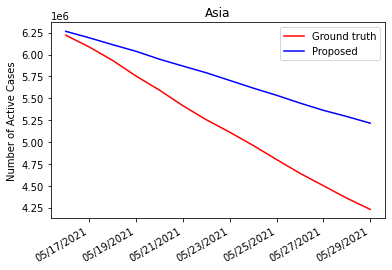

In [267]:
import matplotlib.dates as mdates
dates = [test_start_date + pd.DateOffset(days=i+history_window) for i in range(pred_window)]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, I_true, c='r', label='Ground truth')
plt.plot(dates, pred_I, c='b', label='Proposed')
# stan_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_new", "rb"))
# stan_sirv_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_sirv", "rb"))
# plt.plot(dates, stan_res[-1, :], c='g', label="STAN (SIRV)")
# plt.plot(dates, sir_I[-1, :], c='purple', label="SIRVIC")
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel("Number of Active Cases")
plt.title(continent)
plt.show()

In [268]:
# file_name = './all_models/mlp_' + continent
# state = {
#     'state': model.state_dict(),
#     'optimizer': optimizer.state_dict(),
# }
# torch.save(state, file_name)